In [85]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Load the .fits file
file_path = "sat_interest_25/ETH_20250107_220112_01_satellite.fit"  # Replace with your actual file path
hdul = fits.open(file_path)

# Display the header information (optional)
#print("Header information:")
#print(hdul[0].header)

# Access the data (assuming it's a 2D array with shape [frequency, time])
data = hdul[0].data
print(data.shape)

# Extract frequency and time from header (if provided)
# You may need to adjust these keys based on your file
freq_axis = np.arange(data.shape[0])  # Dummy frequency axis if not provided
freq_axis = hdul[1].data[0][1] * 1000000
time_axis = np.arange(data.shape[1])  # Dummy time axis if not provided
time_axis = hdul[1].data[0][0] / 4

# Close the file
hdul.close()

# Choose a specific frequency index (modify as needed)
frequency_index = 80  # Example: choose the 50th frequency; adjust as per your data
chosen_frequency = freq_axis[frequency_index]  # Get the actual frequency value if freq_axis is defined

print(time_axis.size)

rel_time_start = 900
rel_time_stop = 1100
time_axis_rel = time_axis[rel_time_start:rel_time_stop]


(200, 3600)
3600


In [86]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

c = 299792458 # speed of light in m/s
B = 5.49 # length of Baseline in meters
lam = c/chosen_frequency

def moving_average_smooth(data, window_size=3):
    """
    Smooths a 2D array along the first axis using a moving average.

    Parameters:
        data (ndarray): 2D array to be smoothed.
        window_size (int): Size of the moving average window.

    Returns:
        ndarray: Smoothed 2D array.
    """
    smoothed_data = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'),
        axis=0,
        arr=data
    )
    return smoothed_data


def gaussian(x, I, mu, sigma, A, B):
    return I * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + A*x + B


def theoretical_fit(x, S, omega, phi):
    return S*(1+np.cos(B *omega*x/lam + phi))

print(freq_axis[182])
print(lam)

2224187988.28125
0.12028684174484161


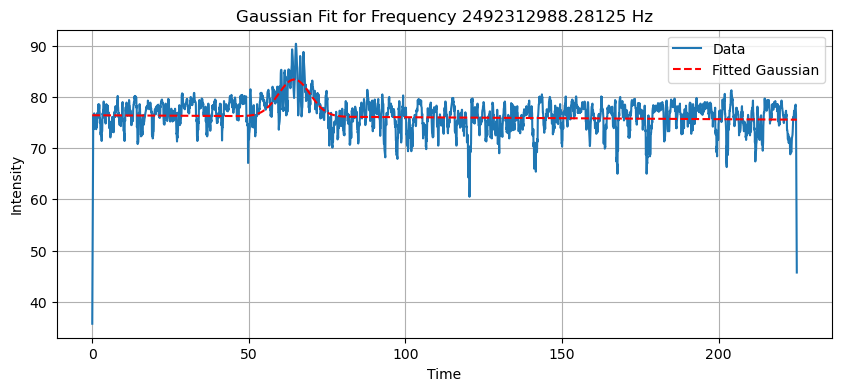

In [87]:
intensity = moving_average_smooth(data[frequency_index, :], window_size=10)

# Fit the Gaussian function (using example Gaussian-like data)
#gaussian_params, _ = curve_fit(gaussian, time_axis, intensity, p0=[17.5, 5720, 4640, 0, 1])
# Fit the Gaussian function with increased maxfev
gaussian_params, _ = curve_fit(
    gaussian,
    time_axis,
    intensity,
    p0=[17.5, 50, 50, 0, 11],
    #p0=[17.5, 5720, 4640, 0, 11],
    maxfev=50000  # Increase maxfev to 5000
)

I, mu, sigma, A, B = gaussian_params

# Generate fitted values for plotting
fitted_gaussian_linear = gaussian(time_axis, I, mu, sigma, A, B)
fitted_gaussian = gaussian(time_axis, I, mu, sigma, 0, 0)



# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis, intensity, label='Data')
plt.plot(time_axis, fitted_gaussian_linear, label='Fitted Gaussian', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Gaussian Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.grid(True)
plt.show()

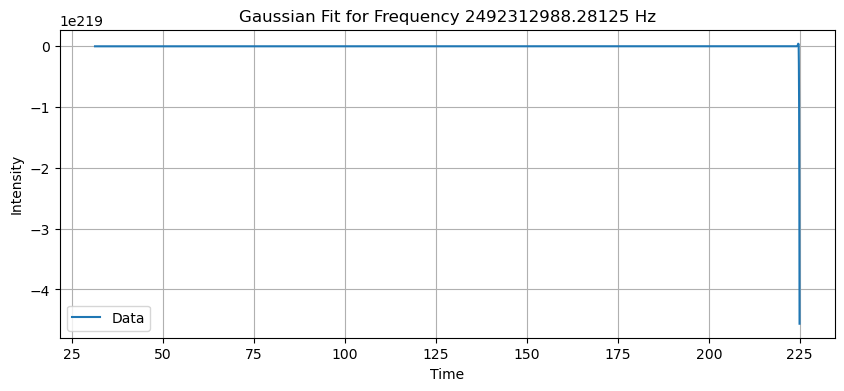

In [88]:
intensity_no_linear = intensity - A*time_axis - B
intensity_no_gauss = intensity_no_linear/fitted_gaussian
# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis[500:], intensity_no_gauss[500:], label='Data')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Gaussian Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.grid(True)
plt.show()


# Fitting the data for theoretical fit (not in use)

[ 0.69020099  1.00441711 -3.14159265]


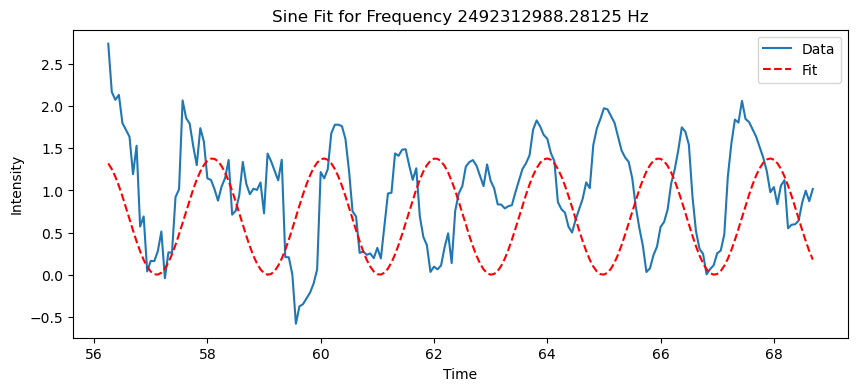

In [89]:
#only relevant time sequence 
intensity_no_gauss_rel = intensity_no_gauss[rel_time_start:rel_time_stop]

def theoretical_fit_norm(x, S, omega, phi):
    return S*(1+np.cos(B *omega*0.005*x/lam + phi))

theo_params, _ = curve_fit(theoretical_fit_norm, time_axis_rel, intensity_no_gauss_rel, p0 = [0.6, 1, 0],bounds=([0, 0, -np.pi], [np.inf, np.inf, np.pi]),  maxfev=2000)
print(theo_params)
S, omega, phi = theo_params

fitted_sin_rel = theoretical_fit_norm(time_axis_rel, S, omega, phi)

# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis_rel, intensity_no_gauss_rel, label='Data')
plt.plot(time_axis_rel, fitted_sin_rel, label='Fit', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Sine Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.show()


[ 0.69022879  0.00502212 -3.14159265]


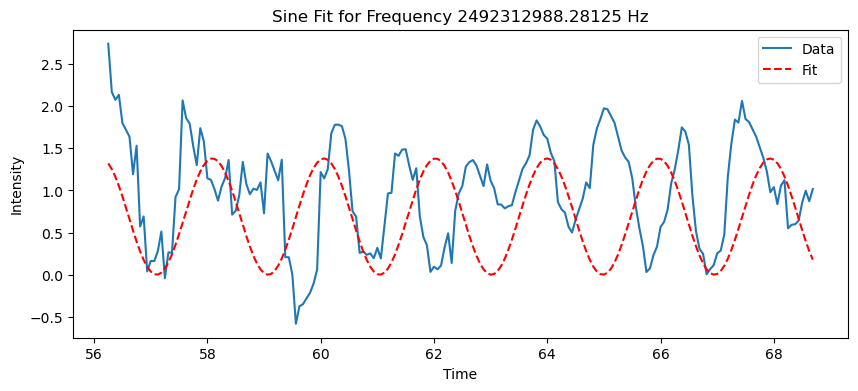

In [90]:

# Initial guesses for parameters: S, omega, phi
initial_guess = [0.8, 0.005, 0.0]

# Perform the curve fitting
popt, pcov = curve_fit(theoretical_fit, time_axis_rel, intensity_no_gauss_rel, p0=initial_guess,bounds=([0, 0, -np.pi], [np.inf, np.inf, np.pi]))
print(popt)
# Extract fitted parameters
S_fit, omega_fit, phi_fit = popt

# Generate the fitted curve
fitted_curve = theoretical_fit(time_axis_rel, S_fit, omega_fit, phi_fit)

# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis_rel, intensity_no_gauss_rel, label='Data')
plt.plot(time_axis_rel, fitted_curve, label='Fit', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Sine Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.show()

# working fit (scipy.optimize)

0.7561374154756582 0.006929104999267174 3.6012791085694644


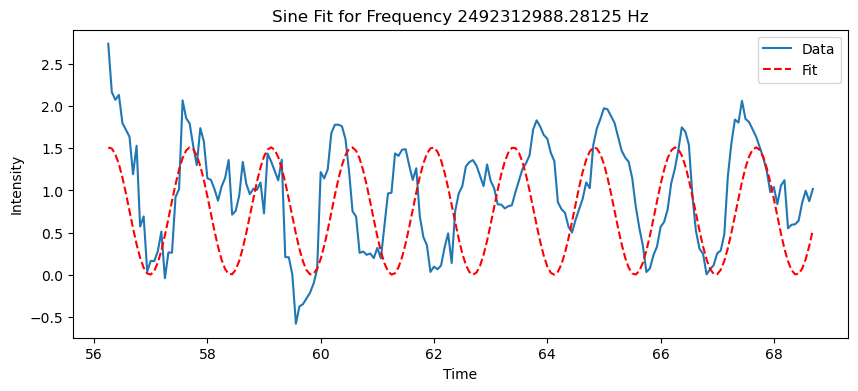

In [91]:
from scipy.optimize import minimize


# Objective function (sum of squared residuals)
def objective(params, x, y):
    S, omega, phi = params
    residuals = y - theoretical_fit(x, S, omega, phi)
    return np.sum(residuals**2)

initial_guess = [0.8, 0.007, 0.0]


result = minimize(objective, initial_guess, args=(time_axis_rel, intensity_no_gauss_rel))

# Extract fitted parameters
S_fit, omega_fit, phi_fit = result.x

print(S_fit, omega_fit, phi_fit)

# Generate the fitted curve
fitted_curve = theoretical_fit(time_axis_rel, S_fit, omega_fit, phi_fit)

# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis_rel, intensity_no_gauss_rel, label='Data')
plt.plot(time_axis_rel, fitted_curve, label='Fit', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Sine Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.show()


# solving for r

In [92]:
import sympy as sp

# Define the symbols
r= sp.symbols('r')

# Constants (with units converted where necessary)
R = 6371 * 1000  # Radius of the Earth in meters
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M = 5.972e24  # Mass of the Earth in kg
a = 14 * 0.01745329 # Beam angle in radians

# Define the equation_fit
equation = r**3 + R*r**2 - (G * M ) / omega_fit**2

# Solve the equation for r
solutions = sp.solve(equation, r)

# Display the solutions
for i, sol in enumerate(solutions):
    print(f"Solution {i + 1}: {sol}")


Solution 1: -6151622.60800651 - 0.e-16*I
Solution 2: -1276547.09970396 + 0.e-16*I
Solution 3: 1057169.70771047 - 0.e-16*I
